In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision as tv
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

from torch_mnf import models
from torch_mnf.utils import ROOT, interruptable, plot_model_preds_for_rotating_img

/Users/janosh/.venv/py310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/janosh/.venv/py310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowExxb)
  Referenced from: '/Users/janosh/.venv/py310/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/janosh/.venv/py310/lib/python3.10/site-packages/torch/lib/libc10.dylib'
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
batch_size = 32

plt.rc("savefig", bbox="tight", dpi=200)
plt.rcParams["figure.constrained_layout.use"] = True
plt.rc("figure", dpi=150)

torch.manual_seed(0)  # ensure reproducible results

In [ ]:
# torchvision.transforms.Normalize() seems to be unnecessary
train_set, test_set = (
    MNIST(ROOT + "/data", transform=ToTensor(), download=True, train=x)
    for x in [True, False]
)

train_loader, test_loader = (
    DataLoader(x, batch_size=batch_size, shuffle=True, drop_last=True)
    for x in [train_set, test_set]
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /Users/janosh/dev/torch-mnf/data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/janosh/dev/torch-mnf/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /Users/janosh/dev/torch-mnf/data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/janosh/dev/torch-mnf/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /Users/janosh/dev/torch-mnf/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/janosh/dev/torch-mnf/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /Users/janosh/dev/torch-mnf/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/janosh/dev/torch-mnf/data/MNIST/raw



In [ ]:
def train_step(model, optim, loss_fn, images, labels):
    # We could draw multiple posterior samples here to get unbiased Monte Carlo
    # estimate for the NLL which would decrease training variance but slow us down.
    optim.zero_grad()
    preds = model(images)
    loss = loss_fn(preds, labels)
    loss.backward()
    optim.step()
    return loss, preds


@interruptable
def train_fn(model, optim, loss_fn, data_loader, epochs=1, log_every=30, writer=None):
    vars(model).setdefault("step", 0)  # add train step counter on model if none exists

    for epoch in range(epochs):
        pbar = tqdm(data_loader, desc=f"epoch {epoch + 1}/{epochs}")
        for samples, labels in pbar:
            model.step += 1

            loss, preds = train_step(model, optim, loss_fn, samples, labels)

            if log_every and model.step % log_every == 0:

                # Accuracy estimated by single call for speed. Would be more
                # accurate to approximately integrate over parameter posteriors
                # by averaging across multiple calls.
                val_preds = model(X_val)
                val_acc = (y_val == val_preds.argmax(1)).float().mean()
                train_acc = (labels == preds.argmax(1)).float().mean()
                pbar.set_postfix(loss=f"{loss:.3}", val_acc=f"{val_acc:.3}")

                if writer:
                    writer.add_scalar("accuracy/training", train_acc, model.step)
                    writer.add_scalar("accuracy/validation", val_acc, model.step)

In [ ]:
# Create validation set. If val_set size is larger than batch_size,
# PyTorch needs to recreate the graph after every model call using val_set.
X_val = test_set.data[:batch_size].unsqueeze(1).float() / 255
y_val = test_set.targets[:batch_size]
img9 = test_set[12][0]

In [ ]:
mnf_lenet = models.MNFLeNet()
mnf_adam = torch.optim.Adam(mnf_lenet.parameters())
print(f"MNFLeNet param count: {sum(p.numel() for p in mnf_lenet.parameters()):,}")

writer = SummaryWriter(ROOT + f"/runs/mnf_lenet/{datetime.now():%m.%d-%H:%M:%S}")

MNFLeNet param count: 696,950


In [ ]:
def mnf_loss_fn(preds, labels):
    nll = F.nll_loss(preds, labels).mean()

    # The KL divergence acts as a regularizer to prevent overfitting.
    kl_div = mnf_lenet.kl_div() / len(train_loader)
    loss = nll + kl_div

    writer.add_scalar("loss/NLL", nll, mnf_lenet.step)
    writer.add_scalar("loss/KL div", kl_div, mnf_lenet.step)
    writer.add_scalar("loss/NLL + KL", loss, mnf_lenet.step)

    return loss

In [ ]:
train_fn(mnf_lenet, mnf_adam, mnf_loss_fn, train_loader, writer=writer)

epoch 1/1: 100%|██████████| 1875/1875 [01:02<00:00, 30.20it/s, loss=1.1e+02, val_acc=1.0]   


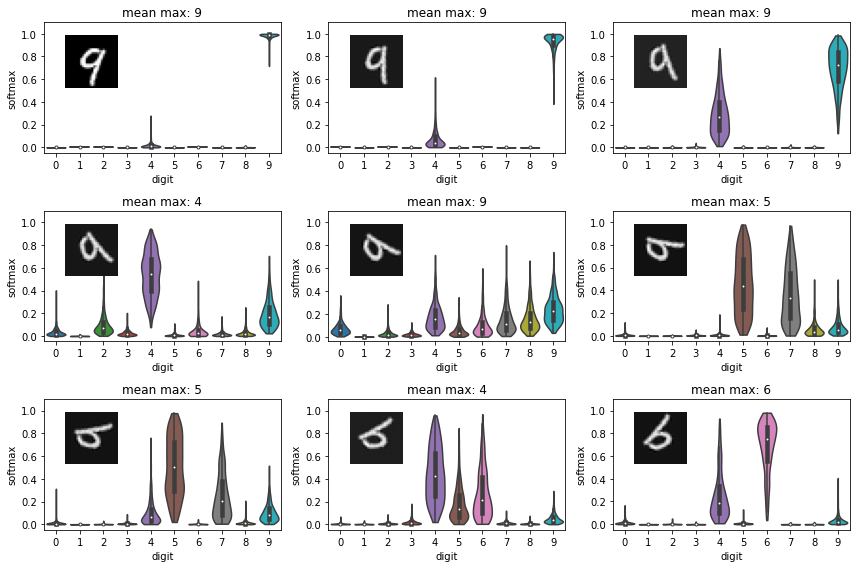

In [ ]:
def make_parallel_mnf_preds(img, model=mnf_lenet, n_preds=500):
    # repeat the same image along axis 0 to run multiple forward passes in parallel
    return model(torch.tensor(img.repeat(n_preds, 0))).exp().detach().numpy()


plot_model_preds_for_rotating_img(make_parallel_mnf_preds, img9)

In [ ]:
grid = tv.utils.make_grid(X_val)
writer.add_image("MNIST examples", grid, 0)
writer.add_graph(mnf_lenet, X_val)  # add model graph to TensorBoard summary
writer.close()

/Users/janosh/.venv/py310/lib/python3.10/site-packages/torch/jit/_trace.py:983: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 319 / 320 (99.7%)
Greatest absolute difference: 6.153434753417969 at index (27, 6) (up to 1e-05 allowed)
Greatest relative difference: 44.99975371357843 at index (27, 4) (up to 1e-05 allowed)

  _check_trace(


In [ ]:
lenet = models.LeNet()
lenet_adam = torch.optim.Adam(lenet.parameters(), lr=1e-3)
print(f"LeNet param count: {sum(p.numel() for p in lenet.parameters()):,}")

LeNet param count: 258,582


In [ ]:
def lenet_loss_fn(preds, labels):
    return F.nll_loss(preds, labels).mean()


train_fn(lenet, lenet_adam, lenet_loss_fn, train_loader)

epoch 1/1: 100%|██████████| 1875/1875 [00:23<00:00, 80.97it/s, loss=0.00437, val_acc=1.0]  


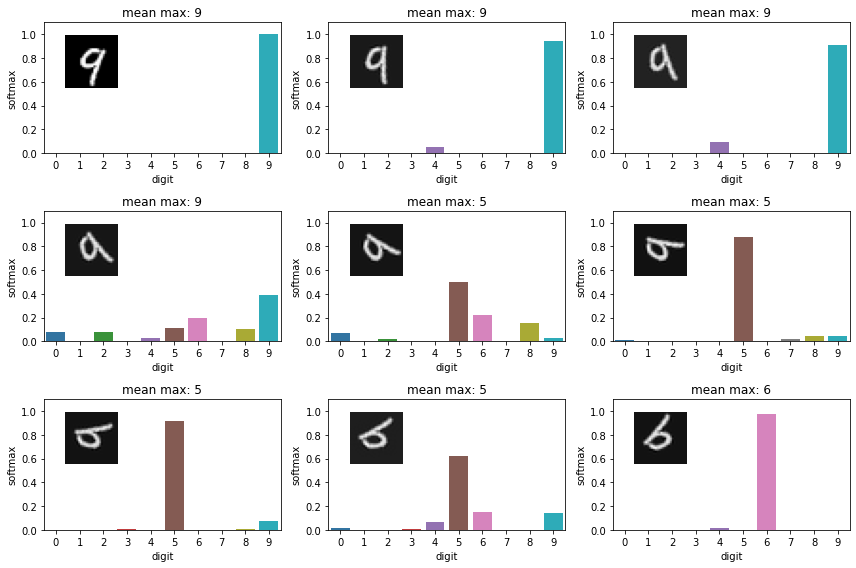

In [ ]:
plot_model_preds_for_rotating_img(
    lambda x: lenet(torch.tensor(x)).exp().detach().numpy(), img9, plot_type="bar"
)